# Codes for the social network analysis and community structure analysis
- Written by Hiroki Koda at Primate Research Institute, Kyoto University
- 2021-11-04

## 1. Preparation

### 1.1. Module import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance
import networkx as nx
import community
import itertools
import sys
import os
import seaborn as sns

### 1.2. Directory set of the original data file
This depends on the locations of the file directories for own local system. We did not upload the original file here.

In [2]:
data_file_directory = "../../toyoda_caravan_observation/"

### 1.3. Preprocessing of the raw data for the SNA

---
- Read the original single-file movement data of the fourth group in 2019-2020. 
- `df_cameratrap_all` is the single-filemovement data
- `mother_list` is the pandas dataframe of the female lists of the infant-carrying or non-infant carrying females.

In [3]:
df_cameratrap_all = pd.read_excel("{0}progression_order_analysis_marctoides.xlsx".format(data_file_directory))
mother_list = pd.read_excel("{0}progression_order_analysis_marctoides.xlsx".format(data_file_directory), sheet_name = "motherlist")

# omit the 4 subjects, ajiantam, azeno, ekumea and tukamoto because the observations of the 4 monkeys were less than 2.
df_cameratrap = df_cameratrap_all.query("name != 'ajiantam' and name != 'azeno' and name != 'ekumea' and name != 'tukamoto'")

# and, omit the subadult, infant or unkown age classes from the original data (only adult data)
df_cameratrap = df_cameratrap[df_cameratrap.age == 'adult']

# arys were generated
# ary_subject_name: subject name
# ary_subject_id; numerical id of the subject name list
ary_subject_name = df_cameratrap.name.unique()
ary_subject_id = [i for i,sub in enumerate(ary_subject_name)]

# subject name dictionary of the {"name": id} was generated.
dict_sub_id = {"unknown":0}
for i, sub in enumerate(ary_subject_name[ary_subject_name != 'unknown']):
    dict_sub_id_temp = {sub:i+1}
    dict_sub_id = {**dict_sub_id,**dict_sub_id_temp}
 

# map the numerical id to name labels in the datafram of the cameratrap data.
df_cameratrap['name_id'] = df_cameratrap['name'].map(dict_sub_id)

# name list generation and mapping dictionary (name to id number) generated.
name_list = df_cameratrap[df_cameratrap['name'] != "unknown"].name.unique()
mapping = {k: v for k, v in zip(np.arange(len(name_list)), name_list)}


#####################################################################################
#####################################################################################
######## main process of the single file movements###################################
#####################################################################################
#####################################################################################
dist_matrix = np.zeros(shape = (52,52))
for unit_id in df_cameratrap['unit'].unique():
    caravan = df_cameratrap[df_cameratrap['unit'] == unit_id].reset_index().name_id.values
    for i in range(len(caravan) - 1):
        pre_agent_id = caravan[i]
        post_agent_id = caravan[i+1]
        dist_matrix[pre_agent_id,post_agent_id] += 1
        dist_matrix[post_agent_id,pre_agent_id] += 1

#####################################################################################

#####################################################################################
#####################################################################################
####### Genarate adjucency matrix (A) of the single-file movements ##################
#####################################################################################
#####################################################################################
A = dist_matrix[1:,1:]
df_caravan_counts = pd.DataFrame(
    data = A,
    index = list(mapping.values()),
    columns = list(mapping.values()),
)

#######################################################################################

# define the dictionary to map the "nickname" to ID-name (which were defined by Aru Toyoda for the cross-reference in the other papers)
dict_name2ID = dict(pd.read_csv("name2ID.csv", delimiter=",").values)


## 2. Community estimation from the adjancency matrix based on the 20 observations of the single-file movements, by Louvian mthods


### 2.1. The estimation process
1. Apply the Louvian to the single-file movements
2. Score the dyadic relation; if two subjects were in the same community, then its relation set to 1, otherwise 0.
3. Repeat the above 1 and 2 steps for 10,000 times, and convolve the scores to one adjacency matrix, G'
4. Apply the Louvian again to the new matrix, G'.

In [4]:

#######################################################################################
##### 10000 times community clustering by Lovian methods using adjancency matrix A ####
#######################################################################################
#######################################################################################
# iteration to get a scores of the community scores:
n_subject = len(mapping.values())
community_matrix_all_iterations = np.zeros((n_subject,n_subject))
mapping_inverse = d_swap = {v: k for k, v in mapping.items()}
G = nx.from_numpy_matrix(A,create_using = nx.Graph)
# mapping = {k: v for k, v in zip(np.arange(len(name_list)), name_list)}
G = nx.relabel_nodes(G, mapping)
for i in range(10000):
    partition = community.best_partition(G)
    for sub1, sub2 in itertools.product(list(partition.keys()),repeat = 2):
        if partition[sub1] == partition[sub2] and sub1 != sub2:
            i = mapping_inverse[sub1]
            j = mapping_inverse[sub2]
            community_matrix_all_iterations[i,j] += 1
        else:
            pass
# make dataframe in order to save the adjucancy matrix with subject name labels.
df_community_matrix_all_10000_iterations = pd.DataFrame(
    data = community_matrix_all_iterations,
    index = list(mapping.values()),
    columns = list(mapping.values()),
)
# save the 10000 times data as csv
# df_community_matrix_all_10000_iterations.to_csv("df_community_matrix_all_10000_iterations.csv", )
#######################################################################################################################



### 2.2. Drawing the social network from the adjucency matrix generated from the single-file movement data
A main process for the results.
The illustration procedure for the social network and community estimation

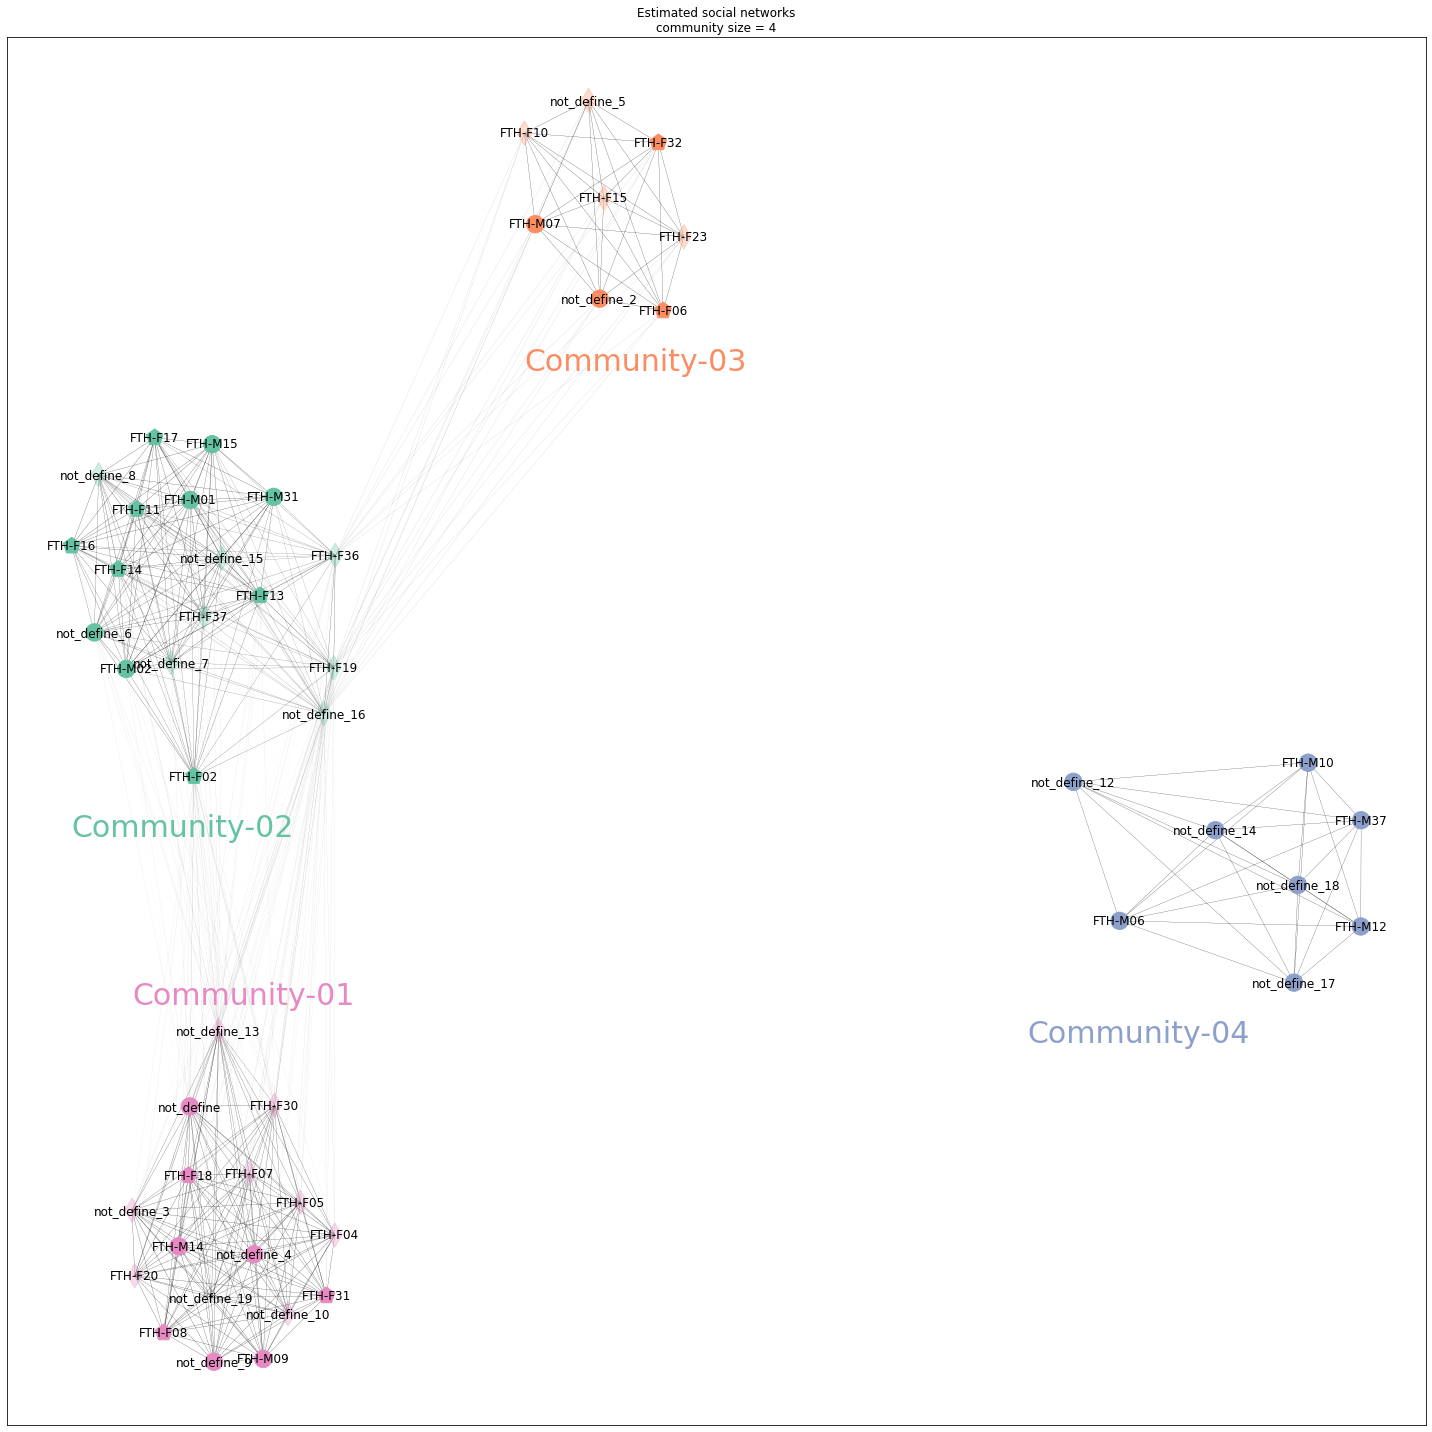

In [5]:
# for the layout replication, fix the seed, but we confirmed the communitry classification were stable in the freely chosen random seed.
np.random.seed(20211210) # by set as executing year/date

# extract the name and generate the dataframe of namelist
name_list = df_cameratrap[df_cameratrap['name'] != "unknown"].name.unique()

# make ID list by mapping name2ID
ID_list = pd.DataFrame({"name":name_list})["name"].map(dict_name2ID).to_numpy()

# make dictionary of the name with sex category
subject_sex_dict = {name_list[i]: df_cameratrap.query("name == '%s'" %name_list[i]).sex.unique()[0] for i in range(len(name_list))}
ID_sex_dict = {dict_name2ID[name_list[i]]: df_cameratrap.query("name == '%s'" %name_list[i]).sex.unique()[0] for i in range(len(name_list))}

# G = nx.from_numpy_matrix(A,create_using = nx.Graph)
# G = nx.from_numpy_matrix(community_matrix_all_iterations_binary,create_using = nx.Graph)
G = nx.from_numpy_matrix(community_matrix_all_iterations/10000,create_using = nx.Graph)

# mapping = {k: v for k, v in zip(np.arange(len(name_list)), name_list)}
mapping = {k: v for k, v in zip(np.arange(len(ID_list)), ID_list)}

G = nx.relabel_nodes(G, mapping)
partition = community.best_partition(G)
pos = nx.spring_layout(G, k = 0.5)
G = nx.relabel_nodes(G,mapping)
G.nodes


plt.close()
plt.figure(figsize = (20,20))
# for (u,v,d) in list(G.edges(data=True)):
#      # print(d['weight'])
#      if d["weight"] < 0.5:
#         G.remove_edge(u, v)
# pos = nx.circular_layout(G)
edge_width = [ d["weight"] * 0.2 for (u,v,d) in list(G.edges(data=True))]

# male_list = [k for k, v in subject_sex_dict.items() if v == 'male']
male_list = [k for k, v in ID_sex_dict.items() if v == 'male']
male_partition_list = [plt.cm.Set2(v) for k ,v in partition.items() if k in male_list]

female_list = [k for k, v in subject_sex_dict.items() if v == 'female']
# female_list = [k for k, v in ID_sex_dict.items() if v == 'female']
mother_female_list = [dict_name2ID[sub] for sub in female_list if sub in mother_list[mother_list.with_infant == 1].name.unique()]
nonmother_female_list = [dict_name2ID[sub] for sub in female_list if sub in mother_list[mother_list.with_infant == 0].name.unique()]

mother_female_partition_list = [plt.cm.Set2(v) for k ,v in partition.items() if k in mother_female_list]
nonmother_female_partition_list = [plt.cm.Set2(v) for k ,v in partition.items() if k in nonmother_female_list]
# female_partition_list = [plt.cm.Set2(v) for k ,v in partition.items() if k in female_list]

# nx.draw_networkx(G,
#                  pos,
#                  node_color=list(partition.values()),
#                  node_shape="d",#["d" if v == "male" else "d" for v in subject_sex_dict.values()],
#                  width=edge_width
#                 )
nx.draw_networkx_nodes(G,
                     pos,
                     nodelist=male_list,  
                     node_color=male_partition_list,
                    #  node_size = copulation_count_list,
                    #  node_shape = ".",
                )
nx.draw_networkx_nodes(G,
                     pos,
                     nodelist=mother_female_list,  
                     node_color=mother_female_partition_list,
                     node_shape = "p",
#                      node_size = [30] * len(mother_female_list),
                )
nx.draw_networkx_nodes(G,
                     pos,
                     alpha = 0.3,
                     nodelist=nonmother_female_list,  
                     node_color=nonmother_female_partition_list,
                     node_shape = "d",
#                      node_size = [10] * len(nonmother_female_list),
                )


nx.draw_networkx_edges(G,
                     pos,
#                      nodelist=female_list,  
#                      node_color=female_partition_list,
#                      node_shape = "d",
#                  node_shape="d",#["d" if v == "male" else "d" for v in subject_sex_dict.values()],
                 width=edge_width
                )

nx.draw_networkx_labels(G,
                     pos,
#                      nodelist=female_list,  
#                      node_color=female_partition_list,
#                      node_shape = "d",
#                  node_shape="d",#["d" if v == "male" else "d" for v in subject_sex_dict.values()],
#                  width=edge_width
                )


estimated_core_n = max(partition.values()) + 1
# evaluation = estimated_core_n / core_n
plt.title('Estimated social networks\ncommunity size = %i' %estimated_core_n)
# calculate the cummunity positions
community_number_1 = partition["FTH-F04"]
community_number_2 = partition["FTH-F36"]
community_number_3 = partition["FTH-F10"]
community_number_4 = partition["FTH-M37"]

pos_g1 = np.array([pos[sub] for sub in {v for v, k in partition.items() if k == community_number_1}])
pos_g2 = np.array([pos[sub] for sub in {v for v, k in partition.items() if k == community_number_2}])
pos_g3 = np.array([pos[sub] for sub in {v for v, k in partition.items() if k == community_number_3}])
pos_g4 = np.array([pos[sub] for sub in {v for v, k in partition.items() if k == community_number_4}])

righest_com = np.argmax([np.max(pos_g1[:,0]),np.max(pos_g2[:,0]),np.max(pos_g3[:,0]),np.max(pos_g4[:,0])])
toppest_com = np.argmax([np.max(pos_g1[:,1]),np.max(pos_g2[:,1]),np.max(pos_g3[:,1]),np.max(pos_g4[:,1])])
leftest_com = np.argmin([np.min(pos_g1[:,0]),np.min(pos_g2[:,0]),np.min(pos_g3[:,0]),np.min(pos_g4[:,0])])
bottomest_com = np.argmin([np.min(pos_g1[:,1]),np.min(pos_g2[:,1]),np.min(pos_g3[:,1]),np.min(pos_g4[:,1])])
xlabel_pos = [0] * 4
xlabel_pos[righest_com] = -0.05
ylabel_pos = [-0.05] * 4
ylabel_pos[bottomest_com] = 0.3

plt.text(x = np.min(pos_g1[:,0]) + xlabel_pos[0], y = np.min(pos_g1[:,1]) + ylabel_pos[0],s = "Community-01", size = 30, c = plt.cm.Set2(community_number_1))
plt.text(x = np.min(pos_g3[:,0]) + xlabel_pos[2], y = np.min(pos_g3[:,1]) + ylabel_pos[2],s = "Community-03", size = 30, color = plt.cm.Set2(community_number_3))
plt.text(x = np.min(pos_g4[:,0]) + xlabel_pos[3], y = np.min(pos_g4[:,1]) + ylabel_pos[3],s = "Community-04", size = 30, color = plt.cm.Set2(community_number_4))
plt.text(x = np.min(pos_g2[:,0]) + xlabel_pos[1], y = np.min(pos_g2[:,1]) + ylabel_pos[1],s = "Community-02", size = 30, color = plt.cm.Set2(community_number_2))
plt.tight_layout()
plt.savefig('png/figure_5_test_toyoda_caravan_sna_10000_iteration.png',dpi=300)

### 2.3. Report the estimated communities

In [6]:
sorted(partition.items(), key=lambda x:x[1])

[('FTH-F17', 0),
 ('FTH-M02', 0),
 ('FTH-F13', 0),
 ('not_define_6', 0),
 ('FTH-F14', 0),
 ('FTH-M31', 0),
 ('FTH-F11', 0),
 ('FTH-F37', 0),
 ('not_define_7', 0),
 ('FTH-F36', 0),
 ('FTH-F19', 0),
 ('FTH-F16', 0),
 ('not_define_8', 0),
 ('FTH-M01', 0),
 ('FTH-M15', 0),
 ('FTH-F02', 0),
 ('not_define_15', 0),
 ('not_define_16', 0),
 ('not_define_2', 1),
 ('FTH-F15', 1),
 ('FTH-F10', 1),
 ('not_define_5', 1),
 ('FTH-F23', 1),
 ('FTH-F32', 1),
 ('FTH-F06', 1),
 ('FTH-M07', 1),
 ('FTH-M12', 2),
 ('FTH-M37', 2),
 ('not_define_12', 2),
 ('FTH-M06', 2),
 ('FTH-M10', 2),
 ('not_define_14', 2),
 ('not_define_17', 2),
 ('not_define_18', 2),
 ('not_define', 3),
 ('FTH-F30', 3),
 ('not_define_3', 3),
 ('FTH-F31', 3),
 ('not_define_4', 3),
 ('FTH-F07', 3),
 ('FTH-F04', 3),
 ('FTH-F18', 3),
 ('FTH-M14', 3),
 ('FTH-F08', 3),
 ('FTH-F20', 3),
 ('not_define_9', 3),
 ('not_define_10', 3),
 ('FTH-F05', 3),
 ('not_define_13', 3),
 ('FTH-M09', 3),
 ('not_define_19', 3)]

## 3. Permutation tests to verify the convergence of the community numbers of the group

### 3.1. Permutation process

In [7]:
estimated_core_n_s = np.zeros(shape = (20,100))

for n in np.arange(20):
    for j in np.arange(100):
        dist_matrix = np.zeros(shape = (52,52))
        for unit_id in np.random.choice(df_cameratrap['unit'].unique(), size = n, replace = False):
            # print(unit_id)
            caravan = df_cameratrap[df_cameratrap['unit'] == unit_id].reset_index().name_id.values
            for i in range(len(caravan) - 1):
                pre_agent_id = caravan[i]
                post_agent_id = caravan[i+1]
                dist_matrix[pre_agent_id,post_agent_id] += 1
                dist_matrix[post_agent_id,pre_agent_id] += 1
        A = dist_matrix[1:,1:]
        name_list = df_cameratrap[df_cameratrap['name'] != "unknown"].name.unique()
        G = nx.from_numpy_matrix(A,create_using = nx.Graph)
        mapping = {k: v for k, v in zip(np.arange(len(name_list)), name_list)}
        G = nx.relabel_nodes(G, mapping)
        partition = community.best_partition(G)
        estimated_core_n = max(partition.values()) + 1
        estimated_core_n_s[n,j] = estimated_core_n

### 3.2. Visualize the permutation results to observe the community number convergences

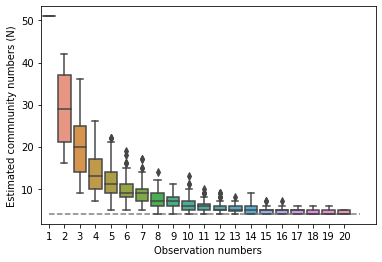

In [8]:
import seaborn as sns
df_estimated_core_n_s = pd.DataFrame()
df_estimated_core_n_s["esitmated_core_size"] = estimated_core_n_s.flatten()
df_estimated_core_n_s["Observation_numbers"] = np.array([[i + 1] * 100 for i in range(20)]).flatten()

sns.boxplot(x = "Observation_numbers", y = "esitmated_core_size", data = df_estimated_core_n_s)
plt.hlines(xmin=0, xmax=20, y=4, linestyles="dashed",colors="grey")
plt.xlabel("Observation numbers")
plt.ylabel('Estimated commnunity numbers (N)')
plt.savefig('png/figure_4_boxplot_estimated_core_number_by_observation.png', dpi = 300)
plt.savefig('eps/figure_4_boxplot_estimated_core_number_by_observation.eps')